In [86]:
import numpy as np
import pandas as pd
import pickle
import scipy as sp
import shap
import torch

from datasets import Dataset, DatasetDict
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_recall_curve, PrecisionRecallDisplay, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tqdm.notebook import trange
from ray import tune
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TextClassificationPipeline, TrainingArguments, Trainer

In [2]:
### YOUR PATH HERE
filepath = '.'

# Import the dataset

In [3]:
df = pd.read_csv(filepath + '/data/second_gen/ratings.csv')[1:].fillna('')
df['labels'] = df.apply(lambda x: x['rating_consensus'] if x['rating_consensus'] != '' else x['rating1'] if ((x['rating1'] == x['rating2']) and (x['consensus_reason'] == '') and (x['rating1'] != '')) else 'error', axis=1)
test_df = df[-800:]
train_val_df = df[:-800]
print('Number of samples in all df: {}, Number of samples in test df: {}, Number of samples in train_val df: {}'.format(len(df),len(test_df), len(train_val_df)))

Number of samples in all df: 3933, Number of samples in test df: 800, Number of samples in train_val df: 3133


In [4]:
train_df, val_df = train_test_split (train_val_df, test_size=0.2)

print('Length of train set: {}'.format(len(train_df)))
print('Length of val set: {}'.format(len(val_df)))
print('Number of included in train set: {} for ratio: {:.3f}'.format(train_df['labels'].sum(), train_df['labels'].sum()/len(train_df)))
print('Number of included in val set: {} for ratio: {:.3f}'.format(val_df['labels'].sum(), val_df['labels'].sum()/len(val_df)))

Length of train set: 2506
Length of val set: 627
Number of included in train set: 171.0 for ratio: 0.068
Number of included in val set: 50.0 for ratio: 0.080


In [5]:
df_columns_to_keep = ['text', 'labels']
train_val_df = train_val_df[df_columns_to_keep]
train_df = train_df[df_columns_to_keep]
val_df = val_df[df_columns_to_keep]
test_df = test_df[df_columns_to_keep]

In [6]:
train_val_ds = Dataset.from_pandas(train_val_df)
train_ds = Dataset.from_pandas(train_df)
val_ds = Dataset.from_pandas(val_df)
test_ds = Dataset.from_pandas(test_df)

ds = DatasetDict()
ds['train_val'] = train_val_ds
ds['train'] = train_ds
ds['val'] = val_ds
ds['test'] = test_ds

In [7]:
ds = ds.class_encode_column('labels')

Casting the dataset: 100%|██████████| 1/1 [00:00<00:00, 999.83ba/s]


# Model

In [8]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

In [9]:
def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

tokenized_datasets = ds.map(tokenizer_function, batched=True)

100%|██████████| 1/1 [00:00<00:00,  6.75ba/s]


In [10]:
def compute_single_label_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    metrics = {'accuracy':accuracy_score(labels, predictions), 'f1':f1_score(labels, predictions), 'precision':precision_score(labels, predictions), 'recall':recall_score(labels, predictions)}
    return metrics

## HP search

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([5e-5, 2e-5, 1e-5, 8e-6, 5e-6, 2e-6, 1e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,5,6]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run1', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run1')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([3e-5, 2e-5, 1.2e-5, 1e-5, 8e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,6,8,10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run2', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/transformers_hp_search/ray')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([3e-5, 2e-5, 1.2e-5, 1e-5, 8e-6]),
    'num_train_epochs':tune.choice([1,2,3,4,6,8,10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run2', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run2')

In [ ]:
def model_init():
    return AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)

hp_space = {
    'learning_rate':tune.choice([1.5e-5, 1.2e-5, 1e-5]),
    'num_train_epochs':tune.choice([10]),
    'per_device_train_batch_size':8
}
training_args = TrainingArguments(filepath + '/results/inclusion/run3', evaluation_strategy='epoch', save_strategy='no', disable_tqdm=True)
trainer = Trainer(model_init=model_init, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train'], eval_dataset=tokenized_datasets['val'])
best_model = trainer.hyperparameter_search(hp_space=lambda _: hp_space, direction='maximize', n_trials=40, local_dir=filepath + '/results/inclusion/run3')

### Train test eval model

In [11]:
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)
training_args = TrainingArguments(filepath + '/models/test_set_eval_models/inclusion_biobert', evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/test_set_eval_models/inclusion_biobert/model')

Some weights of the model checkpoint at dmis-lab/biobert-base-cased-v1.2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification we

{'train_runtime': 633.0953, 'train_samples_per_second': 19.795, 'train_steps_per_second': 2.477, 'train_loss': 0.11762488618188975, 'epoch': 4.0}


Model weights saved in ./models/test_set_eval_models/inclusion_biobert/model\pytorch_model.bin


In [12]:
trainer.evaluate(eval_dataset=tokenized_datasets['test'])

The following columns in the evaluation set  don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text.
***** Running Evaluation *****
  Num examples = 800
  Batch size = 8
100%|██████████| 100/100 [00:12<00:00,  7.97it/s]


{'eval_loss': 0.16631275415420532,
 'eval_accuracy': 0.95875,
 'eval_f1': 0.717948717948718,
 'eval_precision': 0.6666666666666666,
 'eval_recall': 0.7777777777777778,
 'eval_runtime': 12.8159,
 'eval_samples_per_second': 62.422,
 'eval_steps_per_second': 7.803,
 'epoch': 4.0}

# Determine thresholds to automatically include or exclude papers
Recall = 1 or precision = 1

In [80]:
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')
tokenizer_kwargs = {'padding':True,'truncation':True,'max_length':512}
model = AutoModelForSequenceClassification.from_pretrained(filepath + '/models/test_set_eval_models/inclusion_biobert/model/', local_files_only=True)
pipe = TextClassificationPipeline(model=model, tokenizer=tokenizer, return_all_scores=True, device=0)

Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading file https://h

In [81]:
scores = []
for i in trange(len(test_ds)):
    scores.append(pipe(test_ds[i]['text'], **tokenizer_kwargs)[0][1]['score'])

  0%|          | 0/800 [00:00<?, ?it/s]

You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


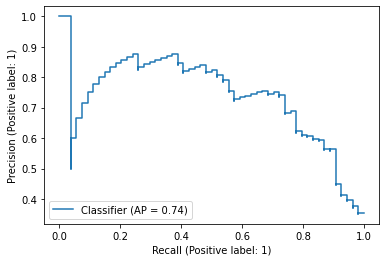

In [85]:
PrecisionRecallDisplay.from_predictions(test_ds['labels'], scores)

In [163]:
pr,re,th = precision_recall_curve(test_ds['labels'], scores)
rth_df = pd.DataFrame.from_dict({'precision':pr[:-1],'recall':re[:-1],'threshold':th})
pth_df = rth_df.reindex(index=rth_df.index[::-1])

In [164]:
ceiling_recall = 0.99
rth_df[rth_df.recall >= ceiling_recall].iloc[-1]

precision    0.355263
recall       1.000000
threshold    0.000826
Name: 0, dtype: float64

In [192]:
recall_threshold = 0.000826
recall_test = []
for i, label, score in zip(range(len(test_ds['labels'])), test_ds['labels'], scores):
    if score >= recall_threshold:
        recall_test.append({'index':i, 'label':label, 'score':score})
print('Number of abstracts excluded from review based on recall threshold: {} out of {} for ratio of {:.3f}'.format(len(test_ds) - len(recall_test), len(test_ds), (len(test_ds) - len(recall_test)) / len(test_ds)))
    

Number of abstracts excluded from review based on recall threshold: 648 out of 800 for ratio of 0.810


In [189]:
i = 28
print('Label: {}, Score: {}\n{}'.format(recall_test[i]['label'], recall_test[i]['score'], test_ds[recall_test[i]['index']]['text']))

Label: 1.0, Score: 0.9916127920150757
Pharmacist-Driven Methicillin-Resistant S. aureus Polymerase Chain Reaction Testing for Pneumonia. BACKGROUND Nasal colonization with methicillin-resistant Staphylococcus aureus (MRSA) can be detected using nasal swab polymerase chain reaction (PCR) assay and is associated with clinical MRSA infection. The MRSA nasal PCR has a rapid turnaround time and a negative predictive value for MRSA pneumonia of >98%; however, data are limited in critically ill patients. OBJECTIVE The purpose of this study is to determine the impact of a pharmacist-driven algorithm, utilizing MRSA PCR nasal screening on duration of anti-MRSA therapy in patients admitted to the intensive care unit (ICU) with suspected pneumonia. METHODS A single-center pre/post study was conducted in 4 ICUs at a large tertiary care community hospital. Adult patients admitted to the ICU initiated on vancomycin or linezolid for pneumonia managed using a pharmacist-driven MRSA PCR algorithm were 

In [197]:
ceiling_precision = 0.88
pth_df[pth_df.precision >= ceiling_precision].iloc[-1]

precision    1.000000
recall       0.037037
threshold    0.995476
Name: 150, dtype: float64

In [198]:
precision_threshold = 0.995476
precision_test = []
for i, label, score in zip(range(len(test_ds['labels'])), test_ds['labels'], scores):
    if score >= precision_threshold:
        precision_test.append({'index':i, 'label':label, 'score':score})
print('Number of abstracts excluded from review based on precision threshold: {} out of {} for ratio of {:.3f}'.format(len(precision_test), len(test_ds), len(precision_test) / len(test_ds)))
    

Number of abstracts excluded from review based on precision threshold: 1 out of 800 for ratio of 0.001


In [201]:
i = 0
print('Label: {}, Score: {}\n{}'.format(precision_test[i]['label'], precision_test[i]['score'], test_ds[precision_test[i]['index']]['text']))

Label: 1.0, Score: 0.9959228038787842
Implementation of a pharmacist-led diabetes management service in an endocrinology clinic. BACKGROUND Diabetes is a complicated health condition that can lead to significant health complications. Pharmacists are in an ideal position to make therapeutic interventions, provide clinical education, and can provide necessary follow-up to evaluate response to therapy for patients with diabetes. OBJECTIVES The primary objective of this study is to evaluate the mean change in hemoglobin A1c (HbA1c) in patients receiving short-term diabetes management services from a clinical pharmacist through collaborative drug therapy management. METHODS This study is a single-center retrospective chart review of patients with diabetes who have been referred by their endocrinologist to the clinical pharmacist for short-term intensification of pharmacologic management of hyperglycemia. Patients included in the study completed at least 2 visits with the pharmacist during t

# Train a production model

In [203]:
all_df = df[df_columns_to_keep]
all_ds = Dataset.from_pandas(all_df)
all_ds = all_ds.class_encode_column('labels')
tokenizer = AutoTokenizer.from_pretrained('dmis-lab/biobert-base-cased-v1.2')

def tokenizer_function(samples):
    return tokenizer(samples['text'], padding="max_length", truncation=True, max_length=512)

tokenized_all_ds = all_ds.map(tokenizer_function, batched=True)

Casting the dataset: 100%|██████████| 1/1 [00:00<00:00, 62.44ba/s]
Could not locate the tokenizer configuration file, will try to use the model config instead.
loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
 

In [204]:
model_version = '0.1'
model = AutoModelForSequenceClassification.from_pretrained('dmis-lab/biobert-base-cased-v1.2', num_labels=2)
training_args = TrainingArguments(filepath + '/models/production_models/inclusion_biobert/v{}'.format(model_version), evaluation_strategy='no', logging_strategy='no', learning_rate=1e-5, num_train_epochs=4)
trainer = Trainer(model=model, args=training_args, compute_metrics=compute_single_label_metrics, train_dataset=tokenized_datasets['train_val'])
trainer.train()
trainer.save_model(filepath + '/models/production_models/inclusion_biobert/v{}'.format(model_version))

loading configuration file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/config.json from cache at C:\Users\maxim/.cache\huggingface\transformers\ece5e89bab3b63a40e413c7f599e6081663cad06eb394e48d5023930733d15a3.ad895c9bc4687ffedea1a4cc498ac3f67ebd2083732981c2a06f548cde7d6582
Model config BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.12.5",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

loading weights file https://huggingface.co/dmis-lab/biobert-base-cased-v1.2/resolve/main/pytorch_model.bin from ca

{'train_runtime': 629.5655, 'train_samples_per_second': 19.906, 'train_steps_per_second': 2.491, 'train_loss': 0.11029928557726802, 'epoch': 4.0}


Model weights saved in ./models/production_models/inclusion_biobert/v0.1\pytorch_model.bin
